## Lecture 12

#### Announcements
* Homework self-reflection due tonight
* Midterm exam wrapper due Sunday night
* P2 survey was not posted, but it is now. Please fill it out by tonight (artifact deadline)


#### Goals
* Be able to implement a basic rectified stereo depth estimation routine.
* Understand why matching is the hard part of stereo vision.
* Know the definition and formation of the stereo cost volume.
* Know why and how to use the normalized cross-correlation cost function for stereo matching.
* Understand the construction of the **intrinsic** and **extrinsic** camera matrices.

In [3]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

#### Outline

* Rectified stereo:

  * depth from disparity reduces stereo vision to the correspondence problem

  * assumed a simple case: this is the **rectified case** where (assumptions)

  * correspondence - sounds familiar, but now it's dense. some metrics:

    * SSD - sum of squared differences
    * SSD - sum of absolute differences
    * CC - cross-correlation: filter the right scanline with the left patch; where product is highest, call it a match; in practice, use NCC instead:
    * NCC - normalized cross-correlation: standardize (subtract mean, divide by std) patches before multiplication to add invariance to photometric changes

  * The **cost volume**: given a matching cost c:

    ```
    for i in rows:
      for j in columns:
        for d in disparities:
          C[i, j, d] = c(img1[i,j], img2[i,j+d])
    ```

    (note that c will usually look at a patch around img[i,j])

In [4]:
left = util.imread_grayfloat("../data/flowers_left.png")
right = util.imread_grayfloat("../data/flowers_right.png")

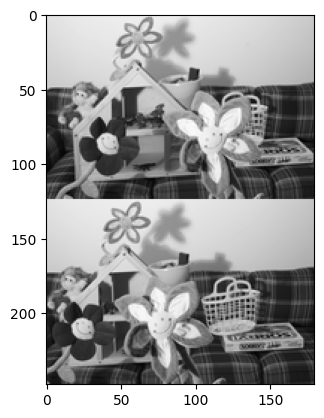

In [5]:
util.imshow_gray(np.vstack((left, right)))

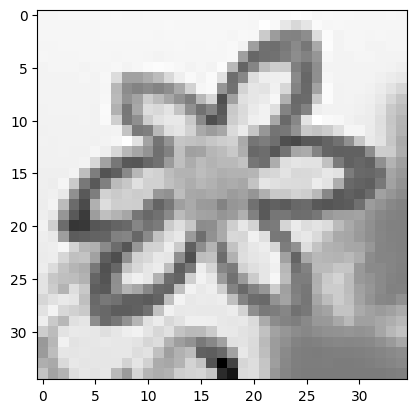

In [7]:
# patch = left[115:125, 205:215]
# patch = left[55:61, 102:107]
patch = left[0:35, 45:80]

util.imshow_gray(patch)

In [9]:
def fast_filter(img, filter):
    return cv2.filter2D(img, -1, filter)

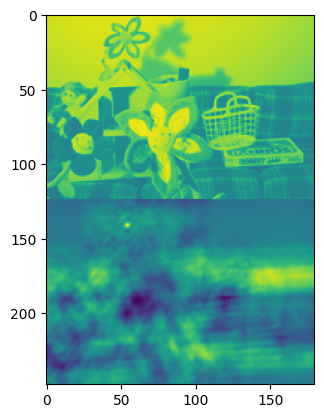

In [10]:
kernel = patch - patch.mean()
xcorr_out = fast_filter(right-right.mean(), patch-patch.mean())
plt.imshow(np.vstack([right, xcorr_out/xcorr_out.max()]))

100%|████████████████████████████████████████████████████████████████████| 120/120 [00:11<00:00, 10.84it/s]


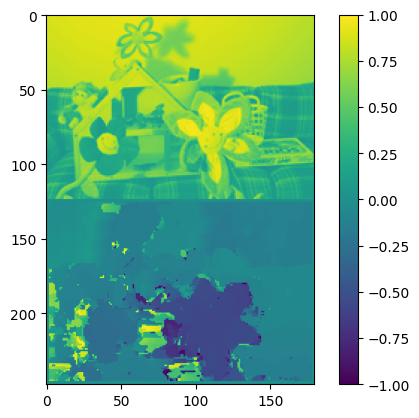

In [29]:
import tqdm

def ncc_cost(left_patch, right_patch):
    lp = (left_patch - left_patch.mean()) / left_patch.std()
    rp = (right_patch - right_patch.mean()) / right_patch.std()
    return (lp * rp).sum()

def ssd_cost(left_patch, right_patch):
    return np.sum((left_patch - right_patch)**2)

def sad_cost(left_patch, right_patch):
    return np.sum(np.abs(left_patch - right_patch))

H, W = left.shape
window = 5
hw = window // 2

disparity_img = np.zeros_like(left)

disparity_limit = 60


for i in tqdm.tqdm(range(hw, H-hw)):
    low_i = i-hw
    high_i = i+hw+1
    for j in range(hw, W-hw):
        low_j = j-hw
        high_j = j+hw+1
        left_patch = left[low_i:high_i, low_j:high_j]
        costs = 1e5 * np.ones((disparity_limit*2+1))
        for d in range(-disparity_limit, disparity_limit+1): # disparities
            if 0 <= low_j+d and high_j+d <= W:
                right_patch = right[low_i:high_i, low_j+d:high_j+d]
                costs[d + disparity_limit] = ssd_cost(left_patch, right_patch)
        disparity_img[i,j] = np.argmin(costs) - disparity_limit

plt.imshow(np.vstack([left, disparity_img/disparity_img.max()]))
plt.colorbar()

In [15]:
np.set_printoptions(suppress=True) # suppress scientific notation

In [31]:
points = np.array([
    [0, 0, -200],
    [-20, 50, -200],
    [-100, 100, -200]
], dtype=np.float64).T

##### HW #2

Suppose a camera is in canonical pose - that is, COP is at world origin, the optical axis runs along the negative z axis, and the projection plane is oriented with $x$ going right and $y$ going up in image space. The focal length of the camera is 100 (this is measured in pixels), and the height and width of the image are also 100. Find the image coordinates (i.e., pixel coordinates that correspond to indices into a numpy array) of the following three 3D points:

* Point 1: $[0, 0, 200]$
* Point 2: $[-20, 50, 200]$
* Point 3: $[-100, 100, 200]$

Keep in mind that in numpy arrays, the origin is at the top left and $y$ goes down.

##### HW #3

Write down the intrinsics matrix $K$ that maps any point from camera coordinates to image coordinates as above. To check your work, make sure that applying the matrix to the three three points in the previous problem yields the expected result.

In [32]:
# HW 3: fill in your intrinsics matrix here:
K = np.array([
    [-100, 0, 50],
    [0, 100, 50],
    [0, 0, 1]
], dtype=np.float64)

# HW 3: verify that K @ points yields the expected pixel coordiantes
points_img = K @ points
points_img = points_img / points_img[2,:]
points_img

array([[50., 40., -0.],
       [50., 25., -0.],
       [ 1.,  1.,  1.]])

Now let's suppose we moved camera. It's now looking at the same points, but the camera center is at $[200, 0, -200]$ and it's rotated 90 degrees "left" - in terms of world coordinates, it's now facing down the negative $x$ axis, with $-z$ going right and $+y$ going up

##### HW #4
4. For world Points 1 and 3 above, give the 3D coordinates of these points in the camera's local coordiante system.

##### HW #5
5. Give a 4x4 frame (i.e., basis plus origin) matrix that describes this camera's pose; the contents of this matrix should be
   $$
   \begin{bmatrix} \mathbf{u} & \mathbf{v} & \mathbf{w} & \mathbf{p}  \\ 0 & 0 & 0 & 1\end{bmatrix}
   $$
   where $\mathbf{u},\mathbf{v},\mathbf{w}$ are the (x, y, and z) basis vectors of the camera's local coordinate system, and $\mathbf{p}$​ is its origin.

##### HW #6
6. The above frame matrix is the "frame-to-canonical" matrix: it converts points represented in the given coordinate frame back into world coordinates. What we want instead for the camera matrix is the opposite: a matrix that transforms world coordinates into camera coordinates. Confirm (using software) that the **inverse** of the matrix that you gave in #5 correctly transforms world coordinates of Points 1 and 3 into the correct camera coordinates you found in #4.


In [23]:
# HW 5: write down the camera frame matrix 
cam_center = np.array([200, 0, -200], dtype=np.float64)
frame = np.array([
    [0, 0, 1, 200],
    [0, 1, 0,   0],
    [-1,0, 0,-200],
    [0, 0, 0, 1]
], dtype=np.float64)
frame

array([[   0.,    0.,    1.,  200.],
       [   0.,    1.,    0.,    0.],
       [  -1.,    0.,    0., -200.],
       [   0.,    0.,    0.,    1.]])

In [33]:
np.linalg.inv(frame)

array([[  -0.,   -0.,   -1., -200.],
       [   0.,    1.,    0.,    0.],
       [   1.,    0.,    0., -200.],
       [   0.,    0.,    0.,    1.]])

In [24]:
# make the 3D points into 3D homogeneous points so they can be translated
points_4d = np.ones((4, 3))
points_4d[:3, :] = points
points_4d

array([[   0.,  -20., -100.],
       [   0.,   50.,  100.],
       [-200., -200., -200.],
       [   1.,    1.,    1.]])

In [26]:
# HWS 6: Apply the inverse frame matrix to get world coordinates to camera coordinates
pts_cam = np.linalg.inv(frame) @ points_4d
pts_cam /= pts_cam[3,:]
pts_cam

array([[   0.,    0.,    0.],
       [   0.,   50.,  100.],
       [-200., -220., -300.],
       [   1.,    1.,    1.]])

##### HW #7
7. Find (again, using software) the final pixel locations of world points 1 and 3.

In [27]:
# make the intrinsics 3x4 so it drops the 4th dimension
K4d = np.zeros((3, 4))
K4d[:3,:3] = K
K4d

array([[-100.,    0.,   50.,    0.],
       [   0.,  100.,   50.,    0.],
       [   0.,    0.,    1.,    0.]])

In [28]:
# HW7: find the final pixel locations of the points in the transformed camera
points_img = K4d @ pts_cam
points_img /= points_img[2,:]
print(points_img)

[[50.         50.         50.        ]
 [50.         27.27272727 16.66666667]
 [ 1.          1.          1.        ]]
